# **<center>POST-Natural Prototypes<center>**

---




> **Aim** - In this project we intend to establish meaningful dialogue between plant and human beings, that is contextualized to how plants and humans will have to adapt to in order to survive. The central objective is to study plant images, and based on its results produce meaningful response that helps plant to grow. The response involves changes in the environmental stresses that includes temperature,sound, light, parasites, and so on. In the initial phase, we will be concentrating on Sound parameter.  

> Our dataset includes 3 types of images – Bioluminescence, fluorescence, and Thermal.

> In this notebook, we will examine Green fluorescent protein(GFP) which is one of the Fluorescence plants (glows in dark).  





## Import libraries

In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==2.9.2

In [2]:
import argparse
import csv
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import functools
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from keras import applications
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn import preprocessing
import numpy as np
import pandas
from sklearn import (
    decomposition,
    manifold,
    pipeline,
)

plt.style.use('ggplot')
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Connecting to google drive and extracting GFP data folder

In [3]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/gfp.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

Mounted at /content/drive/


## Data exploration 

Read a csv file, which is the list of all gfp images names present in the trainset. It consist of 2 columns named as 'id' and 'gfp'. The column 'id' is the serial number and the column 'gfp' is the image file name.  

In [4]:
data = pandas.read_csv("data.csv")

In [5]:
print("Total images in trainset -",len(data))

print("columns in data.csv file -",data.columns)

Total images in trainset - 186
columns in data.csv file - Index(['id', 'gfp'], dtype='object')


FEATURE EXTRACTION 

**get_feature()** -  This functin is reponsible for loading an image and resizing it to 224 x 224 dimension. Hence this will result in 50176 features.

In [6]:
def get_feature(model, metadata):
    print('{}'.format(metadata['id']))
    try:
        img_path = os.path.join('gfp', metadata['gfp'])
        print(img_path)
        if os.path.isfile(img_path):
            #print('is file: {}'.format(img_path))
            try:
                # load image setting the image size to 224 x 224
                img = image.load_img(img_path, target_size=(224, 224))
                # convert image to numpy array
                x = image.img_to_array(img)

                # the image is now in an array of shape (3, 224, 224)
                # but we need to expand it to (1, 2, 224, 224) as Keras is expecting a list of images
                x = np.expand_dims(x, axis=0)
                x = preprocess_input(x)
                
                # extract the features
                features = model.predict(x)[0]
                # convert from Numpy to a list of values
                features_arr = np.char.mod('%f', features)

                return {"id": metadata['id'], "features": ','.join(features_arr)}
            except Exception as ex:
                # skip all exceptions for now
                print(ex)
                pass
    except Exception as ex:
        # skip all exceptions for now
        print(ex)
        pass
    return None


create_features() - This method will create a tsv file that consist of features mapped with each images

In [7]:
def create_features(filename,features):
  with open(filename, 'w') as output:
    w = csv.DictWriter(output, fieldnames=['id', 'features'], delimiter='\t', lineterminator='\n')
    w.writeheader()
    w.writerows(features)


Using VGG 16 model for extracting features of an image. 

In [8]:
data = pandas.read_csv("data.csv")
file = "features_"

# VGG-16
model_vgg16 = applications.vgg16.VGG16(weights='imagenet', include_top=False, pooling='avg')
features_vgg16 = map(functools.partial(get_feature,model_vgg16), data.T.to_dict().values())
# remove empty entries
features_vgg16 = filter(None, features_vgg16)
create_features(file+"vgg16.tsv",features_vgg16)





58889256/58889256 [==============================] - 0s 0us/step
1
gfp/37+55 cc24.png
1/1 [==============================] - 1s 1s/step
2
gfp/37+55 cc25.png
1/1 [==============================] - 1s 646ms/step
3
gfp/37+55 cc26.png
1/1 [==============================] - 1s 676ms/step
4
gfp/37+55 cc27.png
1/1 [==============================] - 1s 640ms/step
5
gfp/37+55 cc28.png
1/1 [==============================] - 1s 648ms/step
6
gfp/37+55 cc29.png
1/1 [==============================] - 1s 745ms/step
7
gfp/37+55 cc30.png
1/1 [==============================] - 1s 790ms/step
8
gfp/37+55 cc31.png
1/1 [==============================] - 1s 551ms/step
9
gfp/37+55 cc32.png
1/1 [==============================] - 1s 551ms/step
10
gfp/37+55 cc33.png
1/1 [==============================] - 1s 542ms/step
11
gfp/37+55 cc34.png
1/1 [==============================] - 1s 625ms/step
12
gfp/37+55 cc35.png
1/1 [==============================] - 1s 544ms/step
13
gfp/37+55 cc36.png
1/1 [====================

APPLYING TSNE/PCA/PCA-TSNE
> To reduce the dimentionality of the dataset, using Principle Component Analysis (PCA). As shown in following calculation, considering **n_components = 50** results into **95%** of variance



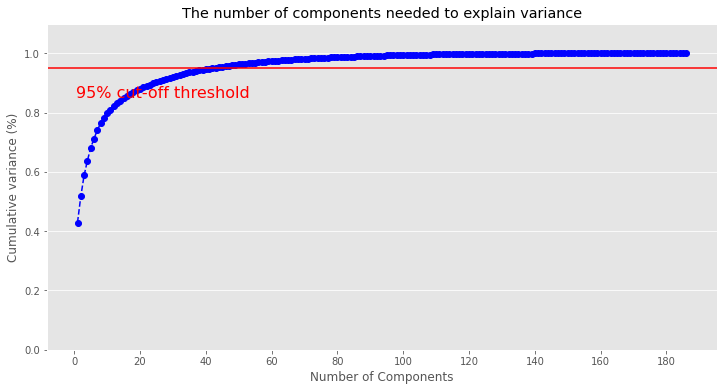

In [12]:
data_vgg16 = pandas.read_csv(file+"vgg16.tsv", sep='\t')

# split the comma delimited string back into a list of values
transformed = [d.split(',') for d in data_vgg16['features']]
# convert image data to float64 matrix. float64 is need for bh_sne
x_data = np.asarray(transformed).astype('float64')
x_data = x_data.reshape((x_data.shape[0], -1))

pca = decomposition.PCA().fit(x_data)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 187, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 187, step=20)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [13]:
def process(data):
    model = decomposition.PCA(n_components=50)
    vis_data = model.fit_transform(x_data)
    # convert the results into a list of dict
    results = []
    for i in range(0, len(data)):
        results.append({
            'id': data['id'][i],
            'x': vis_data[i][0],
            'y': vis_data[i][1]
        })
    return results,model


In [14]:
def write_tsv(results, output_tsv):
    # write to a tab delimited file
    with open(output_tsv, 'w') as output:
        w = csv.DictWriter(
            output, fieldnames=['id', 'x', 'y'], delimiter='\t',
            lineterminator='\n')
        w.writeheader()
        w.writerows(results)


In [15]:
file = "features_"

# VGG-16
data_vgg16 = pandas.read_csv(file+"vgg16.tsv", sep='\t')
results_vgg16,pca_model = process(data_vgg16)
write_tsv(results_vgg16, file+"vgg16_tsne.tsv")


In [16]:
x = []
y = []
# VGG-16
x_vgg16 = []
y_vgg16 = []
for i in results_vgg16:
    x_vgg16.append(i['x'])
    y_vgg16.append(i['y'])
x.append(x_vgg16)
y.append(y_vgg16)
   

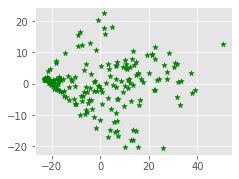

In [17]:
plt.subplot(2,3,1)
plt.scatter(x[0], y[0], label= "stars", color= "green", marker= "*", s=30) 


## Model Training

In [18]:
from sklearn.cluster import KMeans

def kmean_elbow(df):
  distortions = []
  K = range(1,10)
  for k in K:
      kmeanModel = KMeans(n_clusters=k)
      kmeanModel.fit(df)
      distortions.append(kmeanModel.inertia_)

  plt.figure(figsize=(16,8))
  plt.plot(K, distortions, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Distortion')
  plt.title('The Elbow Method showing the optimal k')
  plt.show()

APPLYING KMEANS


> Using K means model for clustering plant images based on extracted features. The above method uses Elbow method to find the optimal value of **k**. Here K is set as 3, resulting into 3 clusters as 0, 1, 2 respectively. 



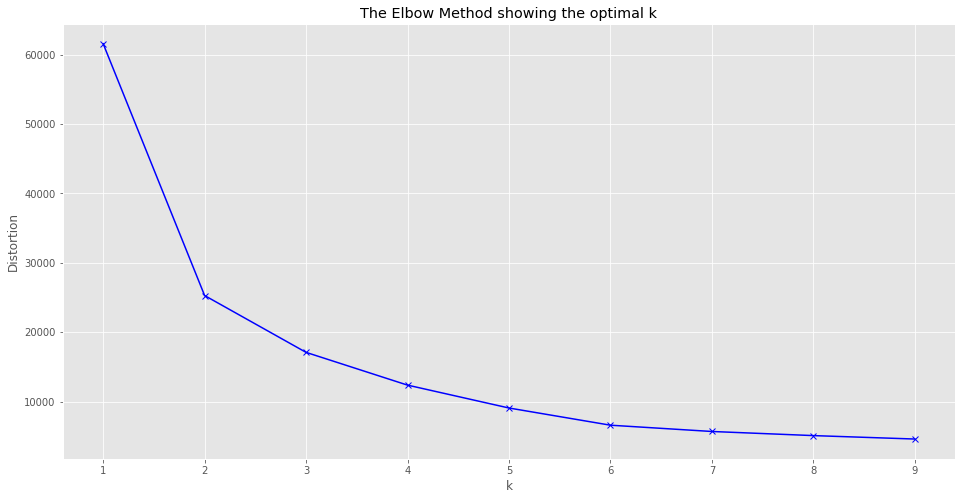

[0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 2 0 0 0 0 0 0 1 2 1 0 1 0 1 0 2 0 1 0 1 2
 1 2 0 0 1 2 0 2 0 2 2 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1
 1 1 1 1 1 0 0 1 1 0 1 0 0 0 2 1 0 2 2 2 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 2 1 1 1 1 1 0 2 1 1 1 1 1 0
 2 1 1 1 0 2 1 0 0 0 1 0 0 0 0 1 1 0 0 0 2 0 1 1 0 1 1 1 1 0 0 2 0 2 0 0 0
 0]


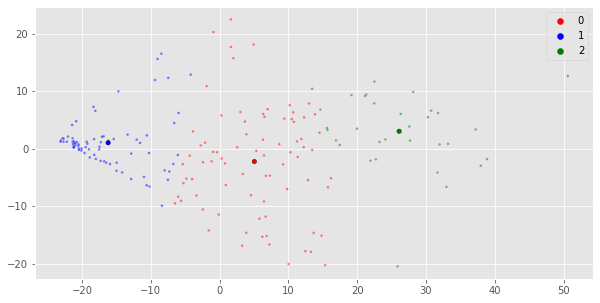

In [19]:
from sklearn.cluster import KMeans

# K-means
f_vgg16 = [[d['x'],d['y'] ] for d in results_vgg16]

kmean_elbow(f_vgg16)
x = np.array(f_vgg16)[:,0]
y = np.array(f_vgg16)[:,1]
kmodel = KMeans(n_clusters=3,random_state=0).fit(f_vgg16)
colors = ['red', 'blue', 'green']
print(kmodel.labels_)
plt.rcParams["figure.figsize"] = (10,5)
ax = sns.scatterplot(x,y, hue=kmodel.labels_, palette=colors, alpha=0.5, s=7)
ax = sns.scatterplot(kmodel.cluster_centers_[:, 0], kmodel.cluster_centers_[:, 1],
                     hue=range(3), palette=colors, s=20, ec='black', legend=False, ax=ax)
plt.show()

One of the requirement for this project is to check if the incoming image falls under the defined thresold when assigned to any of the three cluster. This is because K means always cluterized data points based on the nearest distance from centroid. Therefore, if incoming image is beyond thresold, we will be re-training the model to accomodate the respective image. 


> The thresold is defined as the mean of the distance of data points from its centroid



In [28]:
# squared distance to cluster center
X_dist = kmodel.transform(f_vgg16)**2

df = pandas.DataFrame(X_dist.sum(axis=1).round(2), columns=['sqdist'])
df['label'] = kmodel.labels_
sum_0 = 0
sum_1 = 0
sum_2 = 0
for i,row in df.iterrows():
    if row['label'] == 0:
        sum_0+=row['sqdist']
    elif row['label'] == 1:
        sum_1+=row['sqdist']
    elif row['label'] == 2:
        sum_2+=row['sqdist']

sum_0 = sum_0/(df[df['label'] == 0])['label'].count()
sum_1 = sum_1/(df[df['label'] == 1])['label'].count()
sum_2 = sum_2/(df[df['label'] == 2])['label'].count()
average_dist = [sum_0,sum_1,sum_2]
print("Cluster 0 thresold -",sum_0)
print("Cluster 1 thresold -",sum_1)
print("Cluster 2 thresold -",sum_2)

Cluster 0 thresold - 1314.684358974359
Cluster 1 thresold - 2401.960921052631
Cluster 2 thresold - 2586.038125


## Serializing model - Creating .pickle file

In [27]:
import pickle
pickle.dump(kmodel, open("kmodel.pkl", "wb"))
pickle.dump(pca_model, open("pca.pkl", "wb"))
pickle.dump(average_dist,open("avg_dist.pkl","wb"))

## Model Inference

In [22]:
# load the model
model_k = pickle.load(open("kmodel.pkl", "rb"))
pca_model = pickle.load(open("pca.pkl", "rb"))
avg_dict = pickle.load(open("avg_dist.pkl", "rb"))

In [23]:
def process_test_image(img_path):
      try:
            # load image setting the image size to 224 x 224
            img = image.load_img(img_path, target_size=(224, 224))
            # convert image to numpy array
            x = image.img_to_array(img)
           
            # the image is now in an array of shape (3, 224, 224)
            # but we need to expand it to (1, 2, 224, 224) as Keras is expecting a list of images
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)

            
            model_vgg16 = applications.vgg16.VGG16(weights='imagenet', include_top=False, pooling='avg')
           
            # extract the features
            features = model_vgg16.predict(x)[0]
            # convert from Numpy to a list of values
            features_arr = np.char.mod('%f', features)
            feature_list =  ','.join(features_arr)
            transformed = feature_list.split(',')
         
            # convert image data to float64 matrix. float64 is need for bh_sne
            x_data = np.asarray(transformed).astype('float64')
            x_data = x_data.reshape((1,-1))
            # perform t-SNE
           
            vis_data = pca_model.transform(x_data)


            # convert the results into a list of dict
            results = []
            return vis_data[0][0], vis_data[0][1]
      except Exception as ex:
            # skip all exceptions for now
            print(ex)
            pass


In [24]:
x1,y1 = process_test_image('gfp/37+55 cc50.png')
print([x1,y1])
cluster_id_prediction = model_k.predict(np.array([x1,y1]).reshape((1,-1)))[0]
cluster_distance = min(preprocessing.normalize(model_k.transform(np.array([x1,y1]).reshape((1,-1))))[0])

print(cluster_id_prediction,cluster_distance)

X_dist = kmodel.transform(np.array([x1,y1]).reshape((1,-1)))**2

dist = X_dist.sum(axis=1).round(2)[0]
print(dist)

1/1 [==============================] - 1s 663ms/step
[-0.9466979234024293, -0.5648821057902678]
0 0.19544928552452345
1018.6


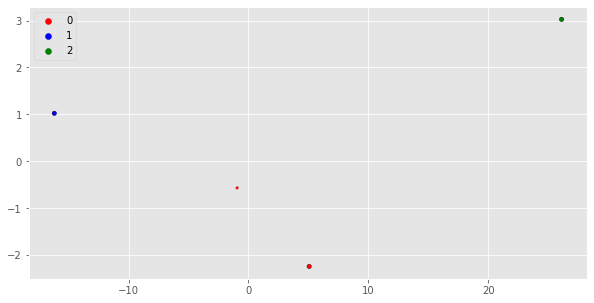

In [25]:
plt.rcParams["figure.figsize"] = (10,5)
ax = sns.scatterplot(x1,y1, hue=kmodel.labels_, palette=colors, alpha=0.5, s=7)
ax = sns.scatterplot(model_k.cluster_centers_[:, 0], model_k.cluster_centers_[:, 1],
                     hue=range(3), palette=colors, s=20, ec='black', legend=False, ax=ax)
plt.show()